In [29]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
# from torch.utils.data.dataset import random_split
from torch.utils.tensorboard import SummaryWriter

from tqdm.auto import tqdm
from datetime import datetime as dt
import os

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [8]:
# Setting the data for testing

np.random.seed(42)
X = np.random.randn(1000, 5)

a = np.array([0.2, 0.1, 0.4, -0.7, 0.03]).reshape(-1, 1)
b = -0.9
y = b + X @ a

print(X.shape, y.shape)

(1000, 5) (1000, 1)


# Data configuration

In [13]:
%%writefile data_config/data_prep.py

np.random.seed(42)
X = np.random.randn(1000, 5)

a = np.array([0.2, 0.1, 0.4, -0.7, 0.03]).reshape(-1, 1)
b = -0.9
y = b + X @ a

X_tensor = torch.as_tensor(X).float()
y_tensor = torch.as_tensor(y).float()

dataset = TensorDataset(X_tensor, y_tensor)

train_size = int(X.shape[0] * 0.8)
valid_size = X.shape[0] - train_size

train_data, valid_data = random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True
)

valid_loader = DataLoader(
    dataset=valid_data,
    batch_size=32
)

Writing data_config/data_prep.py


# Model configuration

In [16]:
%load_ext tensorboard
%tensorboard --logdir summary

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [17]:
%%writefile model_config/model_setting.py

def create_train_step_fn(model, loss_fn, optimizer):
    def output_train_step_loss(X, y):
        model.train()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return output_train_step_loss

def create_valid_step_fn(model, loss_fn):
    def output_valid_step_loss(X, y):
        model.eval()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        return loss.item()
    return output_valid_step_loss

def get_mini_batch_loss(device, data_loader, step_fn):
    mini_batch_losses = []
    for X_batch, y_batch in data_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        batch_loss = step_fn(X_batch, y_batch)
        mini_batch_losses.append(batch_loss)
    
    return np.mean(mini_batch_losses)

lr = 0.01

torch.manual_seed(13)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(nn.Linear(5, 1)).to(device)

loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD(model.parameters(), lr=lr)

train_step_fn = create_train_step_fn(model, loss_fn, optimizer)
valid_step_fn = create_valid_step_fn(model, loss_fn)

tensorboard_writer = SummaryWriter('summary/simple_linear_reg')

Writing model_config/model_setting.py


# Model training

In [18]:
%%writefile model/train.py

n_epochs = 100

train_losses = []
valid_losses = []

for epoch in range(n_epochs):
    train_loss = get_mini_batch_loss(device=device, data_loader=train_loader, step_fn=train_step_fn)
    train_losses.append(train_loss)

    with torch.no_grad():
        valid_loss = get_mini_batch_loss(device=device, data_loader=valid_loader, step_fn=valid_step_fn)
        valid_losses.append(valid_loss)

    tensorboard_writer.add_scalars(
        main_tag = 'losses',
        tag_scalar_dict = {
            'train': train_loss,
            'validation': valid_loss
        },
        global_step = epoch
    )

tensorboard_writer.close()

Writing model/train.py


In [19]:
%run -i data_config/data_prep.py
%run -i model_config/model_setting.py
%run -i model/train.py

In [20]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2000,  0.1000,  0.4000, -0.7000,  0.0300]], device='cuda:0')),
             ('0.bias', tensor([-0.9000], device='cuda:0'))])

# DLAssistant class creation

In [50]:
%%writefile assistent/model.py
class DLAssistant(object):
    
    def __init__(self, model, loss_fn, optimizer):

        self.model = model
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = self.model.to(self.device)

        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.train_loader = None
        self.valid_loader = None
        self.tensorboard_writer = None

        self.train_losses = []
        self.valid_losses = []
        self.total_epochs = 0

        self.train_step_fn = self._create_train_step_fn()
        self.valid_step_fn = self._create_valid_step_fn()

    def to(self, device):

        try:
            self.model = self.model.to(device)
            self.device = device
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            self.model = self.model.to(self.device)
            print(f"{device} device is not accessable!!!\n{self.device} is used!!!")

    def set_loaders(self, train_loader, valid_loader=None):
        self.train_loader = train_loader
        self.valid_loader = valid_loader

    def set_tensorboard(self, name, log_dir='summary'):
        
        if not os.path.exists(log_dir):
            os.mkdir(log_dir)

        name_suffix = dt.now().strftime('%Y%m%d_%H%M%S')
        full_name = f"{log_dir}/{name}_{name_suffix}"
        self.tensorboard_writer = SummaryWriter(full_name)

    def _create_train_step_fn(self):

        def get_train_loss(X, y):
            self.model.train()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        
        return get_train_loss
    
    def _create_valid_step_fn(self):
        
        def get_valid_loss(X, y):
            self.model.eval()
            y_hat = self.model(X)
            loss = self.loss_fn(y_hat, y)
            return loss.item()
        
        return get_valid_loss
    
    def _get_mini_batch_loss(self, validation=False):

        if validation:
            data_loader = self.valid_loader
            step_fn = self.valid_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        mini_batch_losses = []

        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step_fn(X_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        return np.mean(mini_batch_losses)
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):

        self.total_epochs += 1

        self.set_seed(seed)

        for epoch in tqdm(range(n_epochs)):

            train_loss = self._get_mini_batch_loss()
            self.train_losses.append(train_loss)

            with torch.no_grad():
                valid_loss = self._get_mini_batch_loss(validation=True)
                self.valid_losses.append(valid_loss)

            if self.tensorboard_writer is not None:
                scalar_dict = {'train': train_loss}
                if self.valid_loader is not None:
                    scalar_dict.update({'validation': valid_loss})
                self.tensorboard_writer.add_scalars(
                    main_tag = 'losses',
                    tag_scalar_dict = scalar_dict,
                    global_step = epoch
                )

        if self.tensorboard_writer is not None:
            self.tensorboard_writer.flush()

    def show_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.train_losses, label='train', c='blue')
        if self.valid_loader is not None:
            plt.plot(self.valid_losses, label='valid', c='orange')
        plt.yscale('log')
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        return fig
    
    def save_results(self, filepath):
        checkpoint_dict = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'total_epochs': self.total_epochs,
            'train_losses': self.train_losses,
            'valid_losses': self.valid_losses
        }
        torch.save(checkpoint_dict, filepath)

    def load_states(self, filepath):
        checkpoint_dict = torch.load(filepath)
        self.model.load_state_dict(checkpoint_dict['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
        self.total_epochs = checkpoint_dict['total_epochs']
        self.train_losses = checkpoint_dict['train_losses']
        self.valid_losses = checkpoint_dict['valid_losses']

        self.model.train()

    def predict(self, X):
        self.model.eval()
        X_tensor = torch.as_tensor(X).float()
        X_tensor = X_tensor.to(self.device)
        pred_y = self.model(X_tensor).detach().cpu().numpy()
        self.model.train()
        return pred_y

Overwriting assistent/model.py


In [51]:
%run -i data_config/data_prep.py
%run -i model_config/model_setting.py
%run -i assistent/model.py

dl_assistent = DLAssistant(model, loss_fn, optimizer)
dl_assistent.set_loaders(train_loader, valid_loader)
dl_assistent.set_tensorboard(name='class_linear_reg')
dl_assistent.train(n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

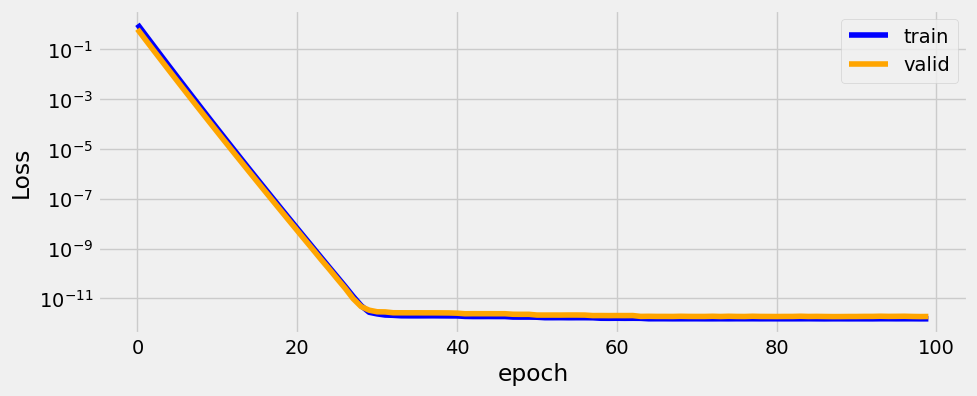

In [52]:
loss_fig = dl_assistent.show_losses();

In [53]:
dl_assistent.model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2000,  0.1000,  0.4000, -0.7000,  0.0300]], device='cuda:0')),
             ('0.bias', tensor([-0.9000], device='cuda:0'))])

In [54]:
dl_assistent.save_results('checkpoint.pth')

In [55]:
dl_assistent.load_states('checkpoint.pth')

In [59]:
X_test = np.random.randn(5, 5)

model_pred = dl_assistent.predict(X_test)
model_pred

array([[-1.5417023 ],
       [-1.1239675 ],
       [-0.59521425],
       [-0.5070373 ],
       [-1.8620882 ]], dtype=float32)